# Yellow-billed Cuckoo - GBIF Records Summary
This notebook is a tool for exploring data sets requested from GBIF (and eventually other sources), and mostly for developing criteria for filtering records.  When the entire notebook is run, it retrieves records according to the filter sets specified and saves the results (records and some summary tables) in an sqlite database.

### General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import numpy as np
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()

### Config file
Some of the scripts below pull common variables from a config file.  This is so in order to reduce redundancy and also facilitates running scripts outside of jupyter notebooks.  However, variables need to be able to be set in notebooks too, so the cell below deletes and then rewrites the config file according to what you want for this notebook.

In [2]:
# Set variables in the following text string, not variable assignment below.
text = """#NOTE! this is overwritten by some notebooks, so update everywhere, if adding lines.
sp_id = 'bybcux0'
summary_name = 'cuckoo'
gbif_req_id = 'GBIFr11'
gbif_filter_id = 'GBIFf3'
ebird_req_id = None
ebird_filter_id = None
evaluation = 'eval_gbif1'
workDir = '/Users/nmtarr/Documents/RANGES/'
codeDir = '/Users/nmtarr/Code/range_map_evaluation/'
inDir = workDir + 'Inputs/'
outDir = workDir + 'Outputs/'
default_coordUncertainty = 100
SRID_dict = {'WGS84': 4326, 'AlbersNAD83': 102008} # Used in file names for output.
spdb = outDir + sp_id + gbif_req_id + gbif_filter_id + '.sqlite'
"""
f = open('config.py', 'w')
f.write(text)
f.close()

import config
species_id = config.sp_id
summary_name = config.summary_name
request_id = config.gbif_req_id
filter_id = config.gbif_filter_id
inDir = config.inDir
outDir = config.outDir
common_name = 'Yellow-billed Cuckoo'

In [3]:
connjup = sqlite3.connect(config.codeDir + 'parameters.sqlite')
cursorjup = connjup.cursor()

## Species Concept

In [4]:
vals = cursorjup.execute("SELECT * FROM species_concepts WHERE species_id = '{0}';".format(species_id)).fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '4,5,6,7,8',
 'common_name': 'yellow-billed cuckoo',
 'detection_distance_meters': 100,
 'end_year': None,
 'error_tolerance': 40,
 'fws_id': None,
 'gap_id': 'bybcux',
 'gbif_id': '2496287',
 'geometry': None,
 'itis_tsn': '177831',
 'migratory': '1',
 'notes': 'Manually entered for use in development. ',
 'pad': 2,
 'scientific_name': 'Coccyzus americanus',
 'species_id': 'bybcux0',
 'start_year': None,
 'wintering_months': '11,12,1,2'}


## Filters

In [5]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(request_id), con=connjup)
print("THE REQUEST FILTER SET")
print(df1.loc[0])

THE REQUEST FILTER SET
request_id                                                          GBIFr11
source                                                                 GBIF
lat_range                                                             27,41
lon_range                                                           -91,-75
years_range                                                       1990,1991
months_range                                                            4,8
geoissue                                                               None
coordinate                                                             True
continent                                                              None
creator                                                             N. Tarr
notes           Used in development.  Should run quickly but provide som...
Name: 0, dtype: object


In [6]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(filter_id), con=connjup)
print("THE POST REQUEST FILTER SET")
print(df2.loc[0])

THE POST REQUEST FILTER SET
filter_id                                                                          GBIFf3
dataset                                                                              GBIF
collection_codes_omit                                                                UMMZ
institutions_omit                                                                   ASNHC
has_coordinate_uncertainty                                                              0
max_coordinate_uncertainty                                                           1000
bases_omit                                                             PRESERVED_SPECIMEN
protocols_omit                                                                           
sampling_protocols_omit                                                                  
issues_omit                                                        GEODETIC_DATUM_INVALID
creator                                                                 

In [7]:
# Run a script that retrieves and filters
%run 'retrieve_occurrences.py'

downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__89%2Fbb%2F19%2F89bb19045ef553fdf3a05056b81618649e77e351 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__db%2Fb5%2F9a%2Fdbb59a7ae14e77d87bd9a6f527f91dd55e577628 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.xml
1817 records exist with the request parameters


### How many records made it through the filters?

In [32]:
conn_occ= sqlite3.connect(config.spdb)
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records")

1795 records


### Were there duplicate records?

In [33]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')

79 records were duplicates based on xy coordinate and date-time


# Institutions
### Pre-filters

In [34]:
institutions = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'institutions';").fetchall()
for x in institutions:
    print(x[0] + " ({0})".format(x[1]))

CLO (1776)
819004460-4 (13)
860013720-1 (1)
ROM (2)
1 (4)
ASNHC (6)
urn:lsid:biocol.org:col:35013 (1)
ND (2)
http://grbio.org/cool/iakn-125z (2)
UMMZ (1)
OMNH (1)
urn:lsid:biocol.org:col:34825 (1)
urn:lsid:biocol.org:col:34777 (2)
urn:lsid:biocol.org:col:34847 (1)
urn:lsid:biocol.org:col:34967 (3)
http://biocol.org/urn:lsid:biocol.org:col:34940 (1)


### Post-filter

In [35]:
institutions = curs_occ.execute("SELECT vals FROM post_filter_attributes WHERE field = 'institutions';").fetchone()[0]
institutions = institutions.replace('[', '').strip().replace(']', '').replace("'", "")
institutions = institutions.split(',')
for ins in institutions:
    print(ins.strip())

NO DISPONIBLE
CLO
ND
Red Nacional de Observadores de Aves (RNOA)


# Collections
### Pre-filters

In [36]:
collections = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'collections';").fetchall()
for x in collections:
    print(x[0] + " ({0})".format(x[1]))

EBIRD (1472)
AVES (13)
EBIRD_TX (246)
MPUJ_Aves (1)
EBIRD_CAN (13)
EBIRD_NJ (1)
EBIRD_VA (6)
Birds (11)
EBIRD_WI (11)
NO DISPONIBLE (4)
EBIRD_QC (6)
EBIRD_MA (2)
Bird specimens (4)
ND (2)
EBIRD_BCN (5)
EBIRD_NH (4)
EBIRD_MEX (2)
birds (1)
Bird (2)
EBIRD_PNW (3)
EBIRD_ARG (1)
EBIRD_PA (3)
EBIRD_VINS (1)
Eggs (3)


### Post-filters

In [37]:
collections = curs_occ.execute("SELECT vals FROM post_filter_attributes WHERE field = 'collections';").fetchone()[0]
collections = collections.replace('[', '').strip().replace(']', '').replace("'", "")
collections = collections.split(',')
for colls in collections:
    print(colls.strip())

EBIRD_BCN
EBIRD_WI
EBIRD_NH
EBIRD_VINS
EBIRD
EBIRD_PNW
EBIRD_TX
EBIRD_MA
EBIRD_QC
ND
EBIRD_MEX
AVES
EBIRD_CAN
EBIRD_VA
EBIRD_NJ
EBIRD_ARG
NO DISPONIBLE
EBIRD_PA


# Bases
### Pre-filter

In [38]:
bases = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'bases';").fetchall()
for x in bases:
    print(x[0] + " ({0})".format(x[1]))

HUMAN_OBSERVATION (1789)
PRESERVED_SPECIMEN (22)
UNKNOWN (4)
OBSERVATION (2)


### Post-filters

In [39]:
bases = curs_occ.execute("SELECT vals FROM post_filter_attributes WHERE field = 'bases';").fetchone()[0]
bases = bases.replace('[', '').strip().replace(']', '').replace("'", "")
bases = bases.split(",")
for bas in bases:
    print(bas.strip())

UNKNOWN
HUMAN_OBSERVATION
OBSERVATION


# Protocols
### Pre-filters

In [40]:
protocols = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'protocols';").fetchall()
for x in protocols:
    print(x[0] + " ({0})".format(x[1]))

DWC_ARCHIVE (1815)
DIGIR (2)


### Post-filters

In [41]:
protos = curs_occ.execute("SELECT vals FROM post_filter_attributes WHERE field = 'protocols';").fetchall()[0]
for pro in protos:
    pro = pro.replace('[', '').strip().replace(']', '').replace("'", "")
    print(pro)

DWC_ARCHIVE, DIGIR


# Issues
### Pre-filters

In [42]:
issues = curs_occ.execute("SELECT value, count FROM post_request_value_counts WHERE attribute = 'issues';").fetchall()
for x in issues:
    print(x[0] + " ({0})".format(x[1]))

COORDINATE_ROUNDED (1434)
GEODETIC_DATUM_ASSUMED_WGS84 (28)
ELEVATION_MIN_MAX_SWAPPED (3)
COORDINATE_REPROJECTED (3)
GEODETIC_DATUM_INVALID (2)


### Post-filters

In [43]:
issues = curs_occ.execute("SELECT vals FROM post_filter_attributes WHERE field = 'issues';").fetchone()[0]
issues = issues.replace('[', '').strip().replace(']', '').replace("'", "")
issues = issues.split(',')
for iss in issues:
    print(iss.strip())

GEODETIC_DATUM_ASSUMED_WGS84
ELEVATION_MIN_MAX_SWAPPED
COORDINATE_ROUNDED


# Descriptions of filtered records

### Locations

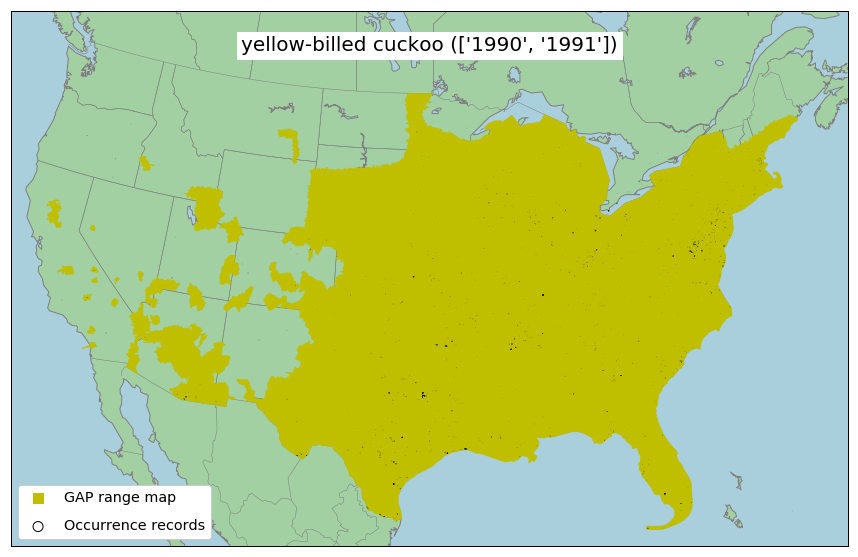

In [44]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
if os.path.isfile(gap_range2 + ".shp"):
    map_these=[shp1, shp2]
else:
    map_these=[shp2]
    
title="{1} ({0})".format(years, common_name)
functions.MapShapefilePolygons(map_these=map_these, title=title)

### Years represented

Text(0.5, 1.0, 'Occurrences per Year')

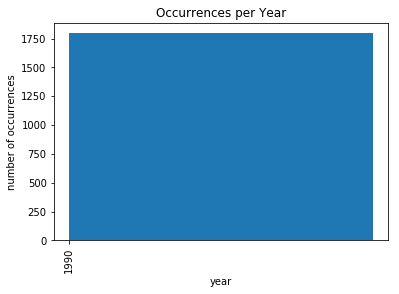

In [45]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
years = connjup.execute("SELECT years_range FROM gbif_requests WHERE request_id = '{0}'".format(config.gbif_req_id)).fetchone()[0]
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

Text(0.5, 1.0, 'Occurrences per Month')

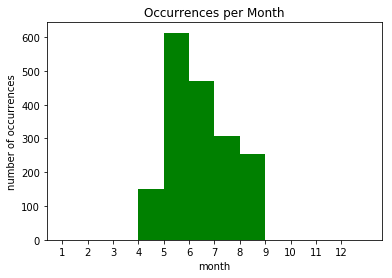

In [46]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

Text(0.5, 1.0, 'Coordinate Uncertainty')

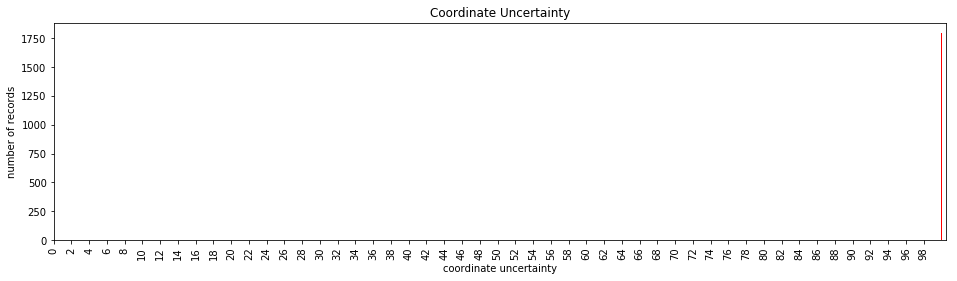

In [47]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

Text(0.5, 1.0, 'Coordinate Uncertainty')

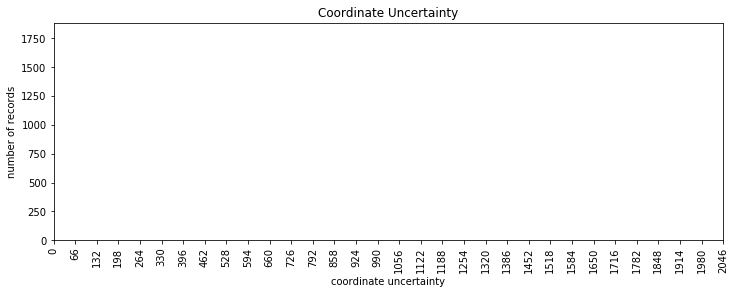

In [48]:
rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### Geodetic datums present

In [49]:
datums = curs_occ.execute("SELECT vals FROM post_filter_attributes WHERE field = 'datums';").fetchone()[0]
datums = datums.replace('[', '').strip().replace(']', '').replace("'", "")
datums = datums.split()
for datum in datums:
    print(datum)

WGS84


### Establishment means reported

In [50]:
establishment = curs_occ.execute("SELECT vals FROM post_filter_attributes WHERE field = 'establishment';").fetchall()[0]
for est in establishment:
    est = est.replace('[', '').strip().replace(']', '').replace("'", "")
    print(est)

### Identification qualifiers included

In [51]:
quali = curs_occ.execute("SELECT DISTINCT vals FROM post_filter_attributes WHERE field = 'IDqualifier';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)

### Remarks included

In [52]:
remarks = curs_occ.execute("SELECT DISTINCT remarks FROM occurrences;").fetchall()
#remarks = remarks.replace('[', '').strip().replace(']', '').replace("'", "")
#remarks = remarks.split(',')
if len(remarks) <= 20:
    for rem in remarks:
        if rem[0][0:1] == ';':
            print(rem[0][2:])
        else:
            print(rem[0])
else:
    print("More than 20 remarks, consult the occurrence database")

More than 20 remarks, consult the occurrence database


### Sources

In [53]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = [request_id, filter_id]

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

GBIF


### Attributes returned for the records in the request (pre-filters)

In [54]:
fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", conn_occ, index_col='index')
fields_summary.index.name = 'field'
print(fields_summary)

                                  included(n)  populated(n)
field                                                      
acceptedNameUsage                           5             5
acceptedScientificName                   1817          1817
acceptedTaxonKey                         1817          1817
accessRights                               17            17
associatedReferences                        3             3
basisOfRecord                            1817          1817
bibliographicCitation                       7             7
catalogNumber                            1817          1817
class                                    1817          1817
classKey                                 1817          1817
collectionCode                           1817          1817
collectionID                               12            12
continent                                  22            22
coordinateUncertaintyInMeters              16            16
country                                 

### Runtime

In [31]:
t2 = datetime.now()
print(t2 - t1)

0:02:24.025412
